# Xarray and CuPy (Real Examples)


Negin Sobhani, Deepak Cherian, and Max Jones  

------------

## Introduction 

In the previous tutorial, we introduced the powerful combination of Xarray and CuPy for handling multi-dimensional datasets and leveraging GPU acceleration to significantly improve performance. We explored high-level Xarray functions such as groupby, rolling mean, and weighted mean, and compared their execution times with traditional NumPy-based implementations. In this tutorial, we will dive deeper into the subject with a hands-on approach, utilizing a real-world dataset. This will enable us to better understand the practical applications of Xarray and CuPy and how they can be efficiently utilized for real-life data analysis tasks.

In [1]:
import numpy as np
import xarray as xr

In [2]:
import cupy as cp
import cupy_xarray  # Adds .cupy to Xarray objects

#### Reading data

Here we read in a small portion of the data available from the NEX-GDDP-CMIP6 dataset available through the registry of open data on AWS - https://registry.opendata.aws/nex-gddp-cmip6/.

In [3]:
import s3fs

fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)

scenario = "ssp245"
var = "tasmax"
years = list(range(2020, 2022))

file_objs = [
    fs.open(
        f"nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/{scenario}/r1i1p1f1/{var}/{var}_day_ACCESS-CM2_{scenario}_r1i1p1f1_gn_{year}.nc"
    )
    for year in years
]
da = xr.open_mfdataset(file_objs, engine="h5netcdf")[var].load()

We can convert the underlying numpy array to cupy array using `cupy.as_cupy()`. 

In [4]:
da = da.as_cupy()

In [5]:
# Check if data is cupy Array
da.cupy.is_cupy

True

As a first step, let's calculate the mean global temperature 

In [6]:
%%time
# Calculate the mean global temperature
da_mean = da.mean(dim=["lat", "lon"]).compute()
da_mean.cupy.is_cupy

CPU times: user 389 ms, sys: 1.77 ms, total: 391 ms
Wall time: 391 ms


True

### Groupby
The groupby function is used to group data based on one or more dimensions. Here, we'll group our data by the 'time' dimension using CuPy:

In [7]:
%%time
climo_da = da.groupby("time.month").mean("time").compute()
climo_da.cupy.is_cupy

CPU times: user 44.2 ms, sys: 0 ns, total: 44.2 ms
Wall time: 47 ms


True

## Advanced workflows and automatic parallelization using `apply_ufunc`

`xr.apply_ufunc()` can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays, but we want to apply it on our Xarray DataArray.

xr.apply_ufunc() give users capability to run custom-written functions such as parameter calculations in a parallel way. See the Xarray tutorial material on apply_ufunc for more.

In the example below, we calculate the saturation vapor pressure by using apply_ufunc() to apply this function to our Dask Array chunk by chunk.

In [8]:
# return saturation vapor pressure
# using Clausius-Clapeyron equation
def sat_p(t):
    return 0.611 * cp.exp(17.67 * (t - 273.15) * ((t - 29.65) ** (-1)))

In [9]:
%%time
es = xr.apply_ufunc(sat_p, da, output_dtypes=[float]).rename("saturation_vapor_pressure")
print(es.cupy.is_cupy)

True
CPU times: user 102 ms, sys: 11.2 ms, total: 113 ms
Wall time: 119 ms


### Add Plotting (Transfer to CPUs)

We can plot the result, which will involve the data being transferred to the host

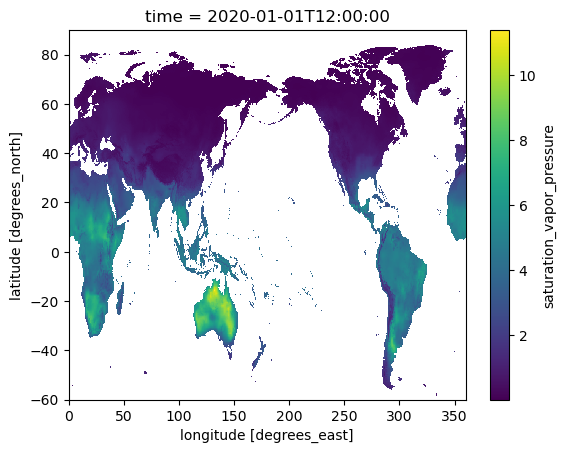

In [10]:
es.isel(time=0).plot()